In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!nvidia-smi

Mon Oct 17 11:33:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    50W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cp -av '/content/drive/MyDrive/coco/pycocotools' '/content/'

'/content/drive/MyDrive/coco/pycocotools' -> '/content/pycocotools'
'/content/drive/MyDrive/coco/pycocotools/_mask.pyx' -> '/content/pycocotools/_mask.pyx'
'/content/drive/MyDrive/coco/pycocotools/__init__.py' -> '/content/pycocotools/__init__.py'
'/content/drive/MyDrive/coco/pycocotools/cocoeval.py' -> '/content/pycocotools/cocoeval.py'
'/content/drive/MyDrive/coco/pycocotools/_mask.c' -> '/content/pycocotools/_mask.c'
'/content/drive/MyDrive/coco/pycocotools/_mask.cp39-win_amd64.pyd' -> '/content/pycocotools/_mask.cp39-win_amd64.pyd'
'/content/drive/MyDrive/coco/pycocotools/mask.py' -> '/content/pycocotools/mask.py'
'/content/drive/MyDrive/coco/pycocotools/coco.py' -> '/content/pycocotools/coco.py'
'/content/drive/MyDrive/coco/pycocotools/__pycache__' -> '/content/pycocotools/__pycache__'
'/content/drive/MyDrive/coco/pycocotools/__pycache__/coco.cpython-39.pyc' -> '/content/pycocotools/__pycache__/coco.cpython-39.pyc'
'/content/drive/MyDrive/coco/pycocotools/__pycache__/__init__.cpyt

In [ ]:
from pycocotools.coco import COCO
import string
from keras.preprocessing.text import Tokenizer
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from tqdm.notebook import tqdm
import os
from PIL import Image, ImageChops
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import time
from random import shuffle

In [ ]:
#1. train_imgs
annFile = "/content/drive/MyDrive/coco/annotations/captions_train2014.json"
coco = COCO(annFile)
imgIds = coco.getImgIds()
#print('len(imgIds)',len(imgIds)) #82783

# get ids of image
imgIds = coco.getImgIds()
# [434084, 108840, ... 537289, 59174] => ids of all images 82783

shuffle(imgIds)

n = 50000
m = n+500
train_ids = imgIds[:n]
test_ids = imgIds[n:m]

print('train_ids',train_ids[:5])
print('test_ids',test_ids[:5])

# get imgs name
train_imgs = []
test_imgs = []

for i in range(len(train_ids)):
    train_imgs.append('COCO_train2014_' + '%012d' % (train_ids[i]) + '.jpg')

for i in range(len(test_ids)):
    test_imgs.append('COCO_train2014_' + '%012d' % (test_ids[i]) + '.jpg')


print('len(train_imgs)',len(train_imgs)) #50000
print(train_imgs[:5])
print(test_imgs[:5])

file = open('/content/drive/MyDrive/Xception_LSTM_coco/training.txt',"w")
file.write(str(train_imgs))
file.close()

file = open('/content/drive/MyDrive/Xception_LSTM_coco/testing.txt',"w")
file.write(str(test_imgs))
file.close()

loading annotations into memory...
Done (t=2.04s)
creating index...
index created!
train_ids [543882, 116732, 507756, 338544, 242516]
test_ids [64765, 69564, 499353, 139263, 480641]
len(train_imgs) 50000
['COCO_train2014_000000543882.jpg', 'COCO_train2014_000000116732.jpg', 'COCO_train2014_000000507756.jpg', 'COCO_train2014_000000338544.jpg', 'COCO_train2014_000000242516.jpg']
['COCO_train2014_000000064765.jpg', 'COCO_train2014_000000069564.jpg', 'COCO_train2014_000000499353.jpg', 'COCO_train2014_000000139263.jpg', 'COCO_train2014_000000480641.jpg']


In [ ]:
#2. train_descriptions
train_descriptions = {}
for i in range(0,len(train_imgs)):
    if train_imgs[i] not in train_descriptions:
        annIds = coco.getAnnIds(imgIds = train_ids[i])
        anns = coco.loadAnns(annIds)
        captions = []
        for j in range(0,len(anns)):
            captions.append(anns[j]['caption'].lower())
        train_descriptions[train_imgs[i]] = captions
print('len(train_descriptions)',len(train_descriptions)) #50000
# print(train_descriptions['COCO_train2014_000000092415.jpg'])

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

clean_descriptions = cleaning_text(train_descriptions)
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Xception_LSTM_coco/descriptions.txt")
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/Xception_LSTM_coco/descriptions.txt", train_imgs)
#print(train_descriptions)

len(train_descriptions) 50000


In [ ]:
# test description
test_descriptions = {}
for i in range(0,len(test_imgs)):
    if test_imgs[i] not in test_descriptions:
        annIds = coco.getAnnIds(imgIds = test_ids[i])
        anns = coco.loadAnns(annIds)
        captions = []
        for j in range(0,len(anns)):
            captions.append(anns[j]['caption'].lower())
        test_descriptions[test_imgs[i]] = captions
print('len(test_descriptions)',len(test_descriptions)) #50000

clean_descriptions = cleaning_text(test_descriptions)
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Xception_LSTM_coco/descriptions_test.txt")
test_descriptions = load_clean_descriptions("/content/drive/MyDrive/Xception_LSTM_coco/descriptions_test.txt", test_imgs)

len(test_descriptions) 500


In [ ]:
#3. max_length
def dict_to_list(train_descriptions):
    all_desc = []
    for key in train_descriptions.keys():
        [all_desc.append(d) for d in train_descriptions[key]]
    return all_desc

def max_length(train_descriptions):
    desc_list = dict_to_list(train_descriptions)
    print('len(desc_list)',len(desc_list)) #250114 (112 images have 6 captions, 1 image has 7 captions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(train_descriptions)
print('max_length',max_length) 



len(desc_list) 250125
max_length 48


In [ ]:
#4. tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

t1 = time.time()

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/Xception_LSTM_coco/tokenizer.p', 'wb'))

t2 = time.time()
time_tokenize = t2 - t1
result_file = '/content/drive/MyDrive/Xception_LSTM_coco/result.txt'
file = open(result_file,"w")
file.write('time_tokenize:\n')
file.write(str(time_tokenize))
file.close()

vocab_size = len(tokenizer.word_index) + 1
print('vocab_size',vocab_size)
print(tokenizer.word_index)

vocab_size 19568
{'end': 1, 'start': 2, 'on': 3, 'of': 4, 'the': 5, 'in': 6, 'with': 7, 'and': 8, 'is': 9, 'man': 10, 'to': 11, 'sitting': 12, 'an': 13, 'two': 14, 'standing': 15, 'at': 16, 'people': 17, 'are': 18, 'next': 19, 'white': 20, 'woman': 21, 'table': 22, 'street': 23, 'that': 24, 'holding': 25, 'person': 26, 'some': 27, 'large': 28, 'it': 29, 'down': 30, 'top': 31, 'group': 32, 'up': 33, 'field': 34, 'small': 35, 'near': 36, 'tennis': 37, 'front': 38, 'his': 39, 'black': 40, 'plate': 41, 'room': 42, 'riding': 43, 'dog': 44, 'train': 45, 'young': 46, 'red': 47, 'by': 48, 'cat': 49, 'water': 50, 'baseball': 51, 'has': 52, 'while': 53, 'playing': 54, 'walking': 55, 'bathroom': 56, 'sign': 57, 'food': 58, 'blue': 59, 'grass': 60, 'kitchen': 61, 'bus': 62, 'pizza': 63, 'there': 64, 'green': 65, 'parked': 66, 'side': 67, 'building': 68, 'other': 69, 'looking': 70, 'snow': 71, 'bed': 72, 'ball': 73, 'beach': 74, 'boy': 75, 'three': 76, 'couple': 77, 'for': 78, 'men': 79, 'flying': 

In [ ]:
#5. train_features
def extract_features(directory, img_set):
    model = Xception(include_top=False, pooling='avg') # or 'avg'
    features = {}
        
    for i in tqdm(range(len(img_set))):        
    # for i in range(len(img_set)):    
        filename = directory + "/" + img_set[i]
        #print(filename)  #COCO_train2014_000000434837.jpg
        image = Image.open(filename)
        image = image.convert("RGB")
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        # image = preprocess_input(image)
        image = image / 127.5
        image = image - 1.0

        feature = model.predict(image)
        # print(feature.shape) # (1, 2048)
        features[img_set[i]] = feature
    return features

# # 2048 feature vector
dataset_images ='/content/drive/MyDrive/coco/train2014'
t1 = time.time()

features = extract_features(dataset_images, train_imgs)
dump(features, open("/content/drive/MyDrive/Xception_LSTM_coco/features.p", "wb"))

t2 = time.time()
time_featurize = t2 - t1
file = open(result_file,"a")
file.write('\ntime_featurize:\n')
file.write(str(time_featurize))
file.close()

t1 = time.time()

features_test = extract_features(dataset_images, test_imgs)
dump(features_test, open("/content/drive/MyDrive/Xception_LSTM_coco/features_test.p", "wb"))

t2 = time.time()
time_featurize = t2 - t1
file = open(result_file,"a")
file.write('\ntime_featurize_test:\n')
file.write(str(time_featurize))
file.close()

def load_features(photos, filename):
    #loading all features
    all_features = load(open(filename,"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features




# def load_features_test(photos):
#     #loading all features
#     all_features = load(open("/content/drive/MyDrive/Xception_LSTM_coco/features_test.p","rb"))
#     #selecting only needed features
#     features = {k:all_features[k] for k in photos}
#     return features

train_features = load_features(train_imgs, '/content/drive/MyDrive/Xception_LSTM_coco/features.p')
test_features = load_features(test_imgs, '/content/drive/MyDrive/Xception_LSTM_coco/features_test.p')

print(len(train_features)) #50000
print(len(test_features))

  0%|          | 0/50000 [00:00<?, ?it/s]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
50000
500


In [ ]:
#6. generator
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # print('seq',seq)
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)
#(45, 2048) (45, 18) (45, 121)

(53, 2048) (53, 48) (53, 19568)


In [ ]:
#7. model
from tensorflow.keras.utils import plot_model


# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    # plot_model(model, to_file='Xception_LSTM.png', show_shapes=True)

    return model

t1 = time.time()

model = define_model(vocab_size, max_length)
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
# making a directory models to save our models
os.mkdir("/content/drive/MyDrive/Xception_LSTM_coco/models")

time_epoch = {}

for i in range(epochs):
    t3 = time.time()
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model_hist = model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("/content/drive/MyDrive/Xception_LSTM_coco/models/model_" + str(i) + ".h5")

    t4 = time.time()
    time_epoch[i] = t4-t3

t2 = time.time()
time_train = t2 - t1
file = open(result_file,"a")
file.write('\ntime_train\n')
file.write(str(time_train))
file.write('\ntime_epochs\n')
file.write(str(time_epoch))
file.close()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 48, 256)      5009408     ['input_12[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_11[0][0]']               
                                                                                            

1/1 [==============================] - 1s 799ms/step


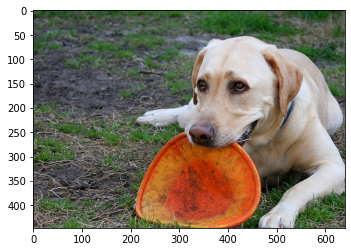

start dog is standing on the grass with frisbee end
1/1 [==============================] - 0s 23ms/step


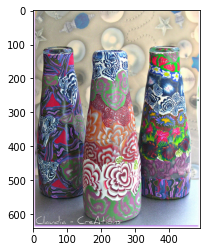

start the table has been displayed and grabs top end
1/1 [==============================] - 0s 24ms/step


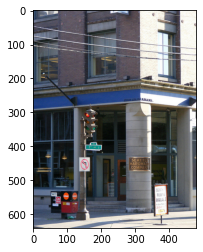

start group of people crossing intersection of store end
1/1 [==============================] - 0s 24ms/step


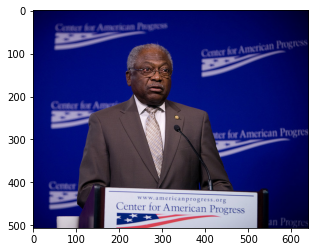

start man in suit and tie standing in crowded crowded street end
1/1 [==============================] - 0s 25ms/step


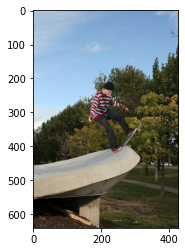

start man is doing trick on his skateboard end
1/1 [==============================] - 0s 23ms/step


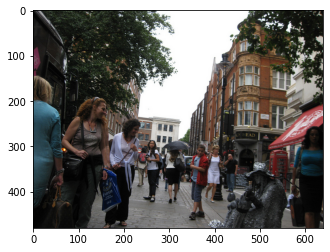

start group of people walking down street with large an umbrella end
1/1 [==============================] - 0s 24ms/step


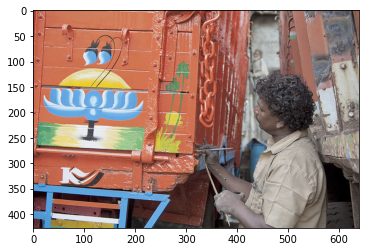

start man is riding bike in front of building end
1/1 [==============================] - 0s 23ms/step


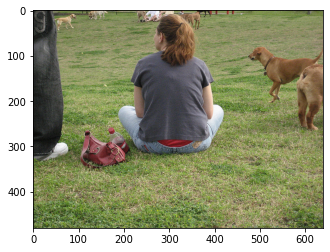

start man with onto red and white dog on leash end
1/1 [==============================] - 0s 23ms/step


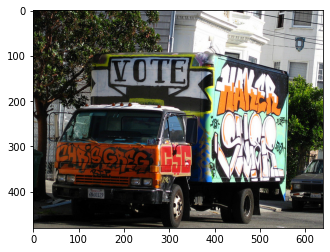

start an old fire truck parked in front of building end
1/1 [==============================] - 0s 23ms/step


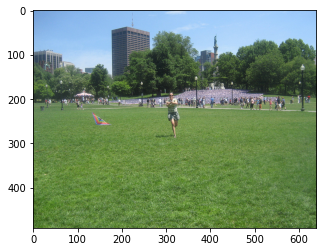

start group of people playing soccer on field end


In [ ]:
# predict some images to test
################################

import matplotlib.pyplot as plt




def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    # print('gen desc')
    # print('photo', photo)

    in_text = 'start'
    for i in range(max_length):
        # print('i',i)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # print('seq1', sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        # print('seq2', sequence)
        pred = model.predict([photo,sequence], verbose=0)
        # print('pred1', pred)
        pred = np.argmax(pred)
        # print('pred2', pred)
        word = word_for_id(pred, tokenizer)
        # print('word', word)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            # print('end here')
            break
    return in_text

model = load_model('/content/drive/MyDrive/Xception_LSTM_coco/models/model_9.h5')
tokenizer = load(open("/content/drive/MyDrive/Xception_LSTM_coco/tokenizer.p","rb"))

# set max_lenght suitable with training data
# max_length = 49

xception_model = Xception(include_top=False, pooling="avg")


for i in range(10):
    img_path = data_folder+test_imgs[i]
    # photo = test_features[test_imgs[i]].reshape((1,2048))
    photo = extract_features(img_path, xception_model)

    # print(photo)

    x=plt.imread(img_path)
    plt.imshow(x)
    plt.show()

    print(generate_desc(model, tokenizer, photo, max_length))
    # print(photo)

In [ ]:
# evaluate the model
##############################
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        #store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

	# calculate BLEU score
    bl1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bl2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bl3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bl4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    print('BLEU-1: %f' % bl1)
    print('BLEU-2: %f' % bl2)
    print('BLEU-3: %f' % bl3)
    print('BLEU-4: %f' % bl4)

    # meteor score
    mt = 0
    for i in range(len(predicted)):
        mt += round(meteor_score(actual[i], predicted[i]),4)
    mt = mt/len(predicted)
    print('METEOR: %f' % mt)

    file = open(result_file,"a")
    file.write('\nBLEU-1: %f' % bl1)
    file.write('\nBLEU-2: %f' % bl2)
    file.write('\nBLEU-3: %f' % bl3)
    file.write('\nBLEU-4: %f' % bl4)
    file.write("\nMETEOR %f" %mt)
 
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  0%|          | 0/500 [00:00<?, ?it/s]

BLEU-1: 0.383951
BLEU-2: 0.221610
BLEU-3: 0.155865
BLEU-4: 0.074713
METEOR: 0.233322


In [ ]:
print(photo)

[[0.04722598 0.10847235 0.10642195 ... 0.46749446 0.00661703 0.00197484]]


In [ ]:
# print(train_imgs[0])
# print(test_imgs[0])
print(type(test_descriptions))
print(type(test_features))

<class 'dict'>
<class 'dict'>


In [ ]:
print(word_for_id(29, tokenizer))

it
